In [3]:
%pip install tensorflow-gpu==2.7.0 opencv-python tensorflow_datasets matplotlib pycocotools numpy;

  Using cached tensorflow_datasets-4.5.2-py3-none-any.whl (4.2 MB)
  Using cached matplotlib-3.5.1-cp38-cp38-win_amd64.whl (7.2 MB)
  Using cached pycocotools-2.0.4.tar.gz (106 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Using cached dill-0.3.4-py2.py3-none-any.whl (86 kB)
  Using cached tqdm-4.64.0-py2.py3-none-any.whl (78 kB)
  Using cached promise-2.3.tar.gz (19 kB)
  Using cached importlib_resources-5.7.1-py3-none-any.whl (28 kB)
  Using cached tensorflow_metadata-1.7.0-py3-none-any.whl (48 kB)
  Using cached fonttools-4.32.0-py3-none-any.whl (900 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached Pillow-9.1.0-cp38-cp38-win_amd64.whl (3.3 MB)
  Using cached kiwisolver-1.4.2-cp38-cp38-win_am

You should consider upgrading via the 'C:\Users\bosq\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


In [1]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\bosq\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


In [2]:
%pip install opencv-python

You should consider upgrading via the 'C:\Users\bosq\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


In [1]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa
import tensorflow as tf
import cv2
import os
import tensorflow_datasets as tfds
import datetime
from coco import COCO
from coco_final_labels import labels as coco_labels
import shutil
from tensorflow.keras.utils import to_categorical
import matplotlib as plt
from tensorflow import keras
from keras import backend as K
import random

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

2022-08-02 17:17:56.920988: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-02 17:17:56.936650: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-02 17:17:56.936843: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
TRAIN_IMAGES = 'data/coco_onehot_train'
VAL_IMAGES = 'data/coco_onehot_val'

In [4]:
resnet50 = keras.applications.ResNet50V2(include_top=False, weights="imagenet", input_shape=(224,224,3))
resnet50.summary()
resnet50.trainable = True

2022-08-02 17:18:00.067281: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-02 17:18:00.068096: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-02 17:18:00.068342: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-02 17:18:00.068485: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 model (Functional)          (None, 343)               28463616  
                                                                 
 model_1 (Functional)        (None, 224, 224, 3)       1583235   
                                                                 
Total params: 30,046,851
Trainable params: 30,001,411
Non-trainable params: 45,440
_________________________________________________________________


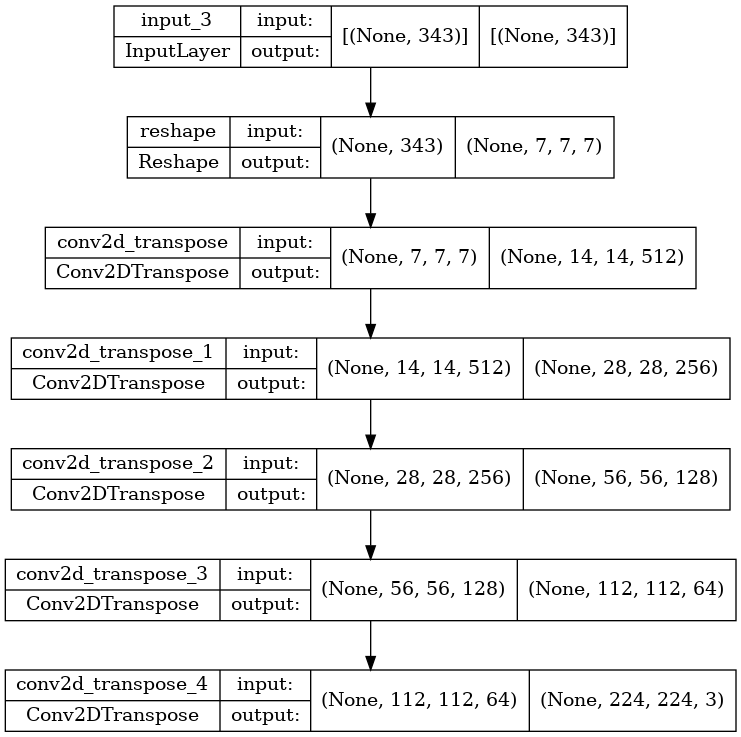

In [5]:
BOTTLENECK_DEPTH = 343

input = Input(shape=(224,224,3))
encoder = resnet50(input)
#encoder_output = Conv2D(BOTTLENECK_DEPTH, 1, activation="relu", padding="same")(encoder)
encoder_output = GlobalAveragePooling2D()(encoder)
encoder_output = Dense(2048, activation="relu")(encoder_output)
encoder_output = Dropout(.02)(encoder_output)
encoder_output = Dense(BOTTLENECK_DEPTH, activation="tanh", use_bias=False)(encoder_output)
encoder_model = Model(inputs=[input], outputs=encoder_output)
#encoder_model.summary()

decoder_input = Input(shape=(BOTTLENECK_DEPTH))
x = Reshape((7,7,7))(decoder_input)
x = Conv2DTranspose(512, 3, 2, padding="same", activation="relu")(x)
x = Conv2DTranspose(256, 3, 2, padding="same", activation="relu")(x)
x = Conv2DTranspose(128, 3, 2, padding="same", activation="relu")(x)
x = Conv2DTranspose(64, 3, 2, padding="same", activation="relu")(x)
x = Conv2DTranspose(3, 3, 2, padding="same", activation="sigmoid")(x)

decoder_model = Model(inputs=decoder_input, outputs=x)
#decoder_model.summary()



autoencoder_input = Input(shape=(224,224,3))
encoder_block = encoder_model(autoencoder_input)
decoder_block = decoder_model(encoder_block)
autoencoder_model = Model(inputs=autoencoder_input, outputs=decoder_block)
autoencoder_model.summary()

tf.keras.utils.plot_model(encoder_model, to_file="logs/autoencoder/encoder_model.png", show_shapes=True, expand_nested=False)

tf.keras.utils.plot_model(decoder_model, to_file="logs/autoencoder/decoder_model.png", show_shapes=True, expand_nested=False)

In [6]:
train_files = {}
for d in os.listdir(TRAIN_IMAGES):
    files = os.listdir(f"{TRAIN_IMAGES}/{d}")
    if len(files) > 0:
        train_files[d] = files

print(len(train_files))

val_files = {}
for d in os.listdir(VAL_IMAGES):
    files = os.listdir(f"{VAL_IMAGES}/{d}")
    if len(files) > 0:
        val_files[d] = files

print(len(val_files))

80
80


In [8]:
import itertools

data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomTranslation(
            height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), fill_mode="nearest"
        ),
        tf.keras.layers.RandomFlip(mode="horizontal"),
        tf.keras.layers.RandomRotation(
            factor=0.15, fill_mode="nearest"
        ),
        tf.keras.layers.RandomZoom(
            height_factor=(-0.3, 0.1), width_factor=(-0.3, 0.1), fill_mode="nearest"
        )
    ]
)

def load_images(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224,224))
    img = img/255.0
    return img

def preprocess_twins(anchor, autoencoded):
    x = load_images(anchor)
    #x = data_augmentation(x, training=True)
    x = tf.image.stateless_random_hue(x, max_delta=0.2, seed=(1,2))
    y = load_images(autoencoded)
    return (x, y)

def preprocess_clustering(anchor, label):
    x = load_images(anchor)
    return (x,label)

def get_training_data(epoch_size=1024, training: bool=True, withlabels: bool=False):
    X = []
    Y = []
    labels = []

    image_set = train_files if training else val_files
    image_dir = TRAIN_IMAGES if training else VAL_IMAGES

    available_classes = coco_labels

    if epoch_size <= 0:
        amount = max([len(files) for files in [image_set[s] for s in image_set.keys()]])
        print(amount)
        for label in available_classes:
            c = itertools.cycle(image_set[label])
            for _ in range(amount):
                anchor = next(c)
                X.append(f"{image_dir}/{label}/{anchor}")
                Y.append(f"{image_dir}/{label}/{anchor}")
                labels.append(available_classes.index(label))
    else:
        for _ in range(epoch_size):

            c = random.choice(available_classes)
            anchor = random.choice(image_set[c])

            X.append(f"{image_dir}/{c}/{anchor}")
            Y.append(f"{image_dir}/{c}/{anchor}")
            labels.append(available_classes.index(c))

    if withlabels:
        return (X,Y,labels)
    return (X, Y)

def get_training_dataset(epoch_size=1024, training: bool=True):
    data = get_training_data(epoch_size, training)
    x = tf.data.Dataset.from_tensor_slices(data[0])
    y = tf.data.Dataset.from_tensor_slices(data[1])
    final_data = tf.data.Dataset.zip((x,y))
    processed_data = final_data.map(preprocess_twins)
    return processed_data

def get_data_for_clustering():
    images = []
    labels = []

    for label in coco_labels:
        c = itertools.cycle(train_files[label])
        for _ in range(100):
            anchor = next(c)
            images.append(f"{TRAIN_IMAGES}/{label}/{anchor}")
            labels.append(coco_labels.index(label))

    x = tf.data.Dataset.from_tensor_slices(images)
    y = tf.data.Dataset.from_tensor_slices(labels)
    final_data = tf.data.Dataset.zip((x,y))
    processed_data = final_data.map(preprocess_clustering)
    return processed_data

def get_data_for_clustering_validation():
    images = []
    labels = []
    for label in coco_labels:
        for file in val_files[label]:
            images.append(f"{VAL_IMAGES}/{label}/{file}")
            labels.append(coco_labels.index(label))
    
    x = tf.data.Dataset.from_tensor_slices(images)
    y = tf.data.Dataset.from_tensor_slices(labels)
    final_data = tf.data.Dataset.zip((x,y))
    processed_data = final_data.map(preprocess_clustering)
    return processed_data


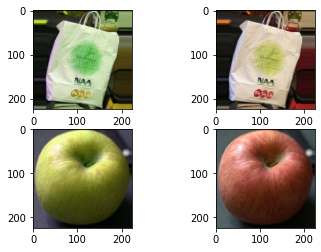

In [15]:
dasd = get_training_dataset(1024).take(2).as_numpy_iterator()

batch = next(dasd)
img1 = np.array(batch[0])
img2 = np.array(batch[1])
batch = next(dasd)
img3 = np.array(batch[0])
img4 = np.array(batch[1])

#img1 = data_augmentation(img1)

f, axarr = plt.pyplot.subplots(2,2)
axarr[0][0].imshow(img1)
axarr[0][1].imshow(img2)
axarr[1][0].imshow(img3)
axarr[1][1].imshow(img4)

In [9]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

opt = tf.keras.optimizers.Adam(learning_rate=0.005)
#autoencoder_model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, metrics=METRICS, loss_weights=[10,80])
autoencoder_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=METRICS)


In [10]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir logs/autoencoder

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'logs/autoencoder/{0}'.format(current_time)
weight_dir = 'weights/autoencoder/{0}'.format(current_time)

summary_writer = tf.summary.create_file_writer(log_dir)
summary_writer.set_as_default()
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, update_freq=100)
weight_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=weight_dir,
    save_weights_only=False,
    monitor='loss',
    save_best_only=True)

Reusing TensorBoard on port 6006 (pid 53190), started 17:25:13 ago. (Use '!kill 53190' to kill it.)

In [11]:
import time
class opencv_draw_callback(keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        if batch % 500 == 0:
            data = get_training_dataset(1, False).as_numpy_iterator()
            data = next(data)
            pred = autoencoder_model.predict(data[0].reshape(-1,224,224,3))
            stack = np.hstack((data[0], pred[0]))
            cv2.imwrite(f"{log_dir}/{str(batch)}_{int(time.time()*1000)}.jpg", stack*255)
            cv2.imshow("inputoutput", stack)
            cv2.waitKey(1000)

opencv_callback = opencv_draw_callback()

In [12]:
train_data = get_training_dataset(-1)
train_data = train_data.shuffle(2048*4)
train_data = train_data.batch(32)
train_data = train_data.prefetch(32)

val_data = get_training_dataset(128, False)
val_data = val_data.batch(32)
val_data = val_data.prefetch(32)

49383


In [13]:

# print(len(data[2]))
loss = autoencoder_model.fit(train_data, batch_size=16, epochs=40, steps_per_epoch=16*128, validation_data=val_data, callbacks=[
    tensorboard_callback, opencv_callback, weight_callback])
print(loss)


Epoch 1/40


2022-08-02 17:18:57.033342: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-08-02 17:18:57.466685: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-02 17:18:58.697727: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2048/2048 [==============================] - ETA: 0s - loss: 0.5811 - tp: 2054625152.0000 - fp: 4756837.0000 - tn: 201968256.0000 - fn: 7603654656.0000 - accuracy: 0.0234 - precision: 0.9977 - recall: 0.2127 - auc: 0.8004 - prc: 0.9940

2022-08-02 17:28:19.845680: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: weights/autoencoder/20220802-171831/assets
2048/2048 [==============================] - 577s 276ms/step - loss: 0.5811 - tp: 2054625152.0000 - fp: 4756837.0000 - tn: 201968256.0000 - fn: 7603654656.0000 - accuracy: 0.0234 - precision: 0.9977 - recall: 0.2127 - auc: 0.8004 - prc: 0.9940 - val_loss: 0.6481 - val_tp: 6499626.0000 - val_fp: 22338.0000 - val_tn: 351407.0000 - val_fn: 12394213.0000 - val_accuracy: 0.0223 - val_precision: 0.9966 - val_recall: 0.3440 - val_auc: 0.7780 - val_prc: 0.9937
Epoch 2/40
2048/2048 [==============================] - 569s 277ms/step - loss: 0.5329 - tp: 3742335744.0000 - fp: 2396119.0000 - tn: 240627344.0000 - fn: 5879646720.0000 - accuracy: 0.0287 - precision: 0.9994 - recall: 0.3889 - auc: 0.8976 - prc: 0.9969 - val_loss: 0.6510 - val_tp: 7349371.0000 - val_fp: 30664.0000 - val_tn: 343081.0000 - val_fn: 11544468.0000 - val_accuracy: 0.0235 - val_precision: 0.9958 - val_recall: 0.3890 - val_auc: 0.7757 - val_prc: 0.99

KeyboardInterrupt: 

In [24]:

encoder_model.save(os.path.join("weights/autoencoder", "encoder2"),)
autoencoder_model.save(os.path.join("weights/autoencoder", "autoencoder2"),)

INFO:tensorflow:Assets written to: weights/autoencoder/encoder2/assets
INFO:tensorflow:Assets written to: weights/autoencoder/autoencoder2/assets


In [28]:
encoder_model = tf.keras.models.load_model(os.path.join("weights/autoencoder", "encoder2"))
autoencoder_model = tf.keras.models.load_model(os.path.join("weights/autoencoder", "autoencoder2"))

In [14]:
dasd = val_data.shuffle(32).take(1).as_numpy_iterator()

batch = next(dasd)
print(len(batch[0]))

32


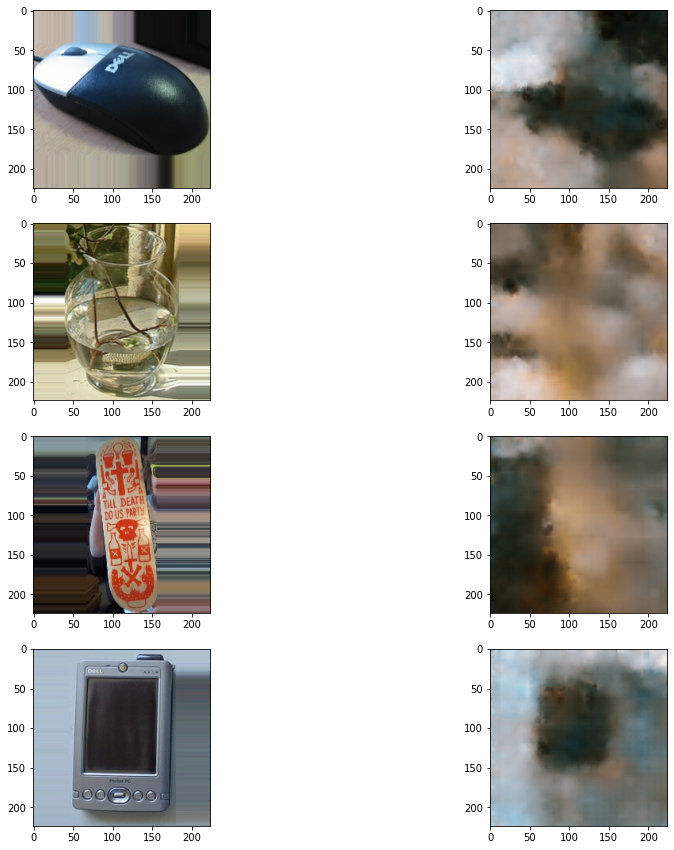

In [15]:

preds = autoencoder_model.predict(batch[1])

img1 = np.array(batch[1][0])
img2 = np.array(batch[1][1])
img3 = np.array(batch[1][2])
img4 = np.array(batch[1][3])

#img1 = data_augmentation(img1)

f, axarr = plt.pyplot.subplots(4,2, figsize=(15, 15))
axarr[0][0].imshow(img1)
axarr[1][0].imshow(img2)
axarr[2][0].imshow(img3)
axarr[3][0].imshow(img4)

axarr[0][1].imshow(preds[0])
axarr[1][1].imshow(preds[1])
axarr[2][1].imshow(preds[2])
axarr[3][1].imshow(preds[3])

In [13]:
data = get_data_for_clustering().as_numpy_iterator()

f = open("weights/autoencoder/features.txt", "w")
for i,x in enumerate(data):
    preds = encoder_model.predict(np.array(x[0]).reshape(-1,224,224,3))
    f.write(f"{[x for x in np.ndarray.flatten(preds[0])]}:{x[1]}\n")

f.close()

KeyboardInterrupt: 

In [63]:
from ast import literal_eval
f = open("weights/autoencoder/features.txt", "r")

x = []
y = []

while True:
    line = f.readline()

    if line == None or len(line) <= 0:
        break

    linesplit = line.split(':')
    #print(line)
    x.append(np.array(literal_eval(linesplit[0])))
    y.append(int(linesplit[1]))

f.close()

# flattened = [np.ndarray.flatten(y) for y in X]

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import cdist

In [9]:
full_components = len(x[0])
full_components

980

In [9]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 90)
  
for k in K:
    print(k)
    # Building and fitting the model
    kmeans = KMeans(init='k-means++', max_iter=1000, n_clusters=k, n_init=3)
    kmeans.fit(x)
  
    distortions.append(sum(np.min(cdist(x, kmeans.cluster_centers_,
                                        'euclidean'), axis=1)) / len(x))
    inertias.append(kmeans.inertia_)
  
    mapping1[k] = sum(np.min(cdist(x, kmeans.cluster_centers_,
                                   'euclidean'), axis=1)) / len(x)
    mapping2[k] = kmeans.inertia_

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89


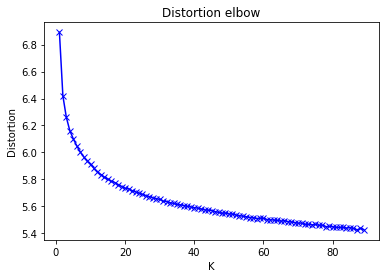

In [18]:
plt.pyplot.plot(K, distortions, 'bx-')
plt.pyplot.xlabel('K')
plt.pyplot.ylabel('Distortion')
plt.pyplot.title('Distortion elbow')
plt.pyplot.show()

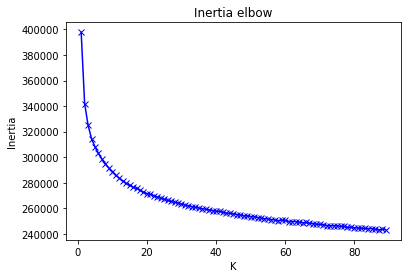

In [19]:
plt.pyplot.plot(K, inertias, 'bx-')
plt.pyplot.xlabel('K')
plt.pyplot.ylabel('Inertia')
plt.pyplot.title('Inertia elbow')
plt.pyplot.show()

In [12]:
# pca = PCA(n_components=50)
# pca.fit(flattened)
kmeans = KMeans(init='k-means++', max_iter=10000, n_clusters=15, n_init=10)
kmeans.fit(x)

#gm = GaussianMixture(n_components=90).fit(flattened)

#clustering_predictions = zip(kmeans.predict(flattened), flattened)

NameError: name 'KMeans' is not defined

In [10]:
data = get_data_for_clustering_validation()
data = data.batch(16)
data = data.prefetch(16)

In [11]:
import time

clustermap = {}

if os.path.exists("logs/autoencoder/clusterviz"):
    shutil.rmtree("logs/autoencoder/clusterviz")

if not os.path.exists("logs/autoencoder/clusterviz"):
    os.mkdir("logs/autoencoder/clusterviz")

for img, y in data:
    pred = encoder_model.predict_on_batch(img)

    for i in range(len(pred)):
        cluster = kmeans.predict([pred[i]])[0]
        print(cluster)
        if cluster not in clustermap:
            clustermap[cluster] = list()
        
        if not os.path.exists(f"logs/autoencoder/clusterviz/{cluster}"):
            os.mkdir(f"logs/autoencoder/clusterviz/{cluster}")

        writeimg = cv2.cvtColor(np.array(img[i]*255), cv2.COLOR_BGR2RGB)
        cv2.imwrite(f"logs/autoencoder/clusterviz/{cluster}/{int(time.time()*1000)}.jpg", writeimg)

        clustermap[cluster].append((pred[i], y[i]))
# for i,x in enumerate(X):
#     p = decoder_model.predict(x)
#     #cv2.imshow("decoder_out", p[0])
#     cluster = clustering.predict(np.ndarray.flatten(x).reshape(1,-1).astype(float))
#     #print(cluster)
#     #cv2.waitKey(1000)
#     cluster_output.append((cluster, p[0]))

2022-08-01 23:48:46.110926: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-08-01 23:48:46.729976: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-01 23:48:47.958623: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


NameError: name 'kmeans' is not defined

<BarContainer object of 15 artists>

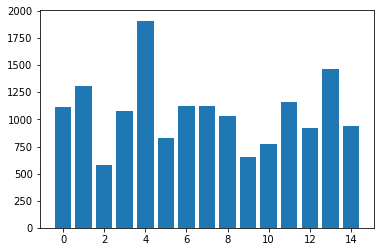

In [124]:
clustersizes = [len(clustermap[c]) for c in clustermap]
clusterindeces = [c for c in clustermap]
plt.pyplot.bar(clusterindeces, clustersizes)

In [22]:
!pip install seaborn

     |████████████████████████████████| 292 kB 345 kB/s eta 0:00:01
     |████████████████████████████████| 11.7 MB 518 kB/s eta 0:00:01
     |████████████████████████████████| 503 kB 1.2 MB/s eta 0:00:01


NameError: name 'clustermap' is not defined

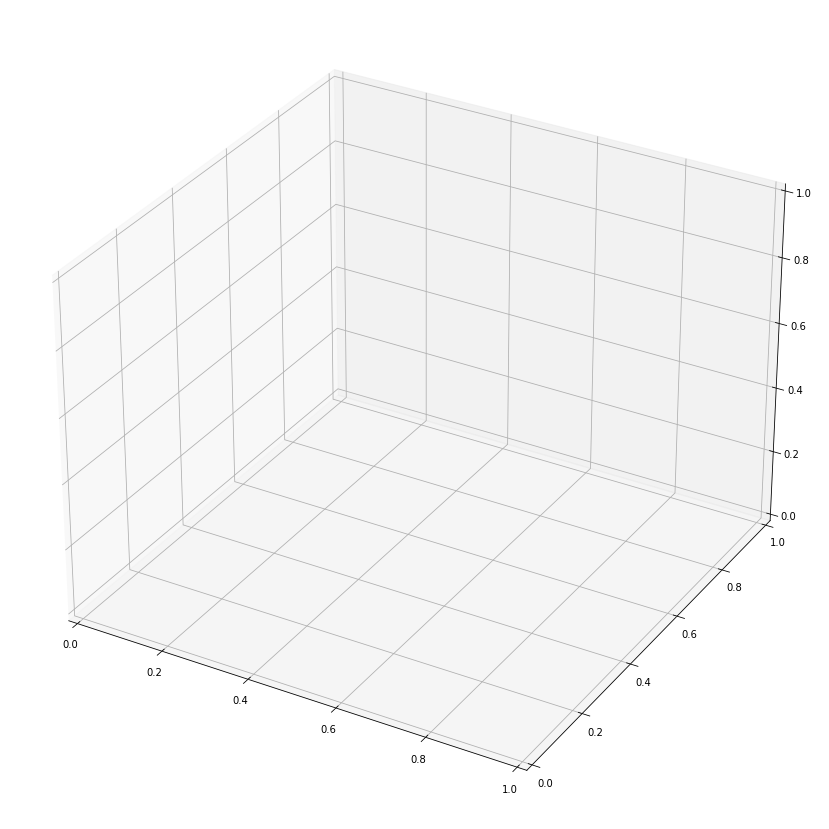

In [8]:
import seaborn as sns

rgb_values = sns.color_palette("Set2", 15)
fig = plt.pyplot.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
t = np.arange(100)

for cluster in clustermap.keys():
    if len(clustermap[cluster]) > 0:
        color = t[cluster]
        _x = [f[0][1] for f in clustermap[cluster]]
        _y = [f[0][0] for f in clustermap[cluster]]
        _z = [f[0][2] for f in clustermap[cluster]]

        ax.scatter(_x,_y,_z, s=15, color=rgb_values[cluster], marker="o")

plt.pyplot.show()

In [88]:
pca = PCA(n_components=0.95, svd_solver='full')
print(x[0])
pca.fit(X=x, y=y)

[-3.84763420e-01 -4.44490600e-02 -1.41493560e-01 -5.09827140e-01
  1.95837320e-01 -2.54555000e-01 -5.42828300e-01  4.43524830e-02
  5.30432100e-02  1.26010780e-01 -1.62123530e-01 -1.69704750e-01
 -1.48608850e-01 -6.05713000e-02  2.96090660e-01 -2.64646600e-01
  1.19234630e-01  1.37308980e-01 -4.29978070e-01  3.32443530e-02
 -4.32122770e-01 -2.60939900e-02 -2.97072920e-01 -3.47183000e-01
  4.58514240e-02 -7.66858400e-02 -5.39498030e-01  3.93652580e-02
  1.39766720e-01  4.82403230e-02 -3.80052830e-01 -1.86840820e-01
 -1.84956340e-01  4.26360200e-02  2.65601840e-01 -5.52642680e-02
 -1.15617680e-01  4.83379850e-02 -2.23770950e-01  1.38884920e-01
 -4.72415600e-01 -4.25190900e-01 -2.83055500e-01 -5.08027000e-01
  1.54268920e-01 -1.13891590e-02 -4.47009270e-01  8.04222900e-02
  3.02730380e-01  2.96269740e-01 -1.08963190e-01 -3.64557030e-01
  2.72976120e-02  5.31780980e-02  1.23976710e-01 -4.15791060e-01
  1.61315170e-01  1.47311960e-01 -4.48614100e-01  6.79851200e-02
 -3.19245960e-01 -5.04155

PCA(n_components=0.95, svd_solver='full')

In [89]:
pca.explained_variance_ratio_

#np.argmax(pca.explained_variance_ratio_)

np.argpartition(pca.explained_variance_ratio_,-10)[-10:]
#(-pca.explained_variance_ratio_).argsort()[:15]

array([9, 8, 7, 6, 5, 4, 3, 2, 1, 0])

In [16]:
import random

num_images = 4
plt.pyplot.figure(figsize=(10, 50))
position = 1
max_clusters = num_images*8

for c in clustermap.keys():
    imgs = os.listdir(f"logs/autoencoder/clusterviz/{c}")
    random.shuffle(imgs)
    for j in range(num_images):
        img = np.ones((32,32,3))
        if len(imgs) > j:
            img = plt.pyplot.imread(f"logs/autoencoder/clusterviz/{c}/{imgs[j]}", format=None)
        plt.pyplot.subplot(max_clusters, num_images, position)
        
        plt.pyplot.imshow(img)
        plt.pyplot.axis("off")
        position += 1
        
    if position > max_clusters:
        break

plt.pyplot.savefig("clsuters.jpg")
# for c in range(90):
#     for j in range(num_images):
#         if len(cluster_instances) <= num_images:
#             continue
#         image_idx = cluster_instances[j][0]
#         plt.subplot(90, num_images, position)
#         plt.imshow((x_train[image_idx]*255.0).astype("uint8"))
#         #plt.title(classes[y_data[image_idx][0]])
#         plt.axis("off")
#         position += 1

NameError: name 'clustermap' is not defined

<Figure size 720x3600 with 0 Axes>

In [15]:
cv2.destroyAllWindows()